In [1]:
# See optimal architecture and results for MNIST here: https://cs229.stanford.edu/proj2015/054_report.pdf. It is just a term report.

import numpy as np
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import ssl
import matplotlib.pyplot as plt
ssl._create_default_https_context = ssl._create_unverified_context
from train import train, evaluate
from data import load_data
from kd import KineticDescentUB
from torch.optim.lr_scheduler import ReduceLROnPlateau

# MNIST

KD-UB: Final Train Acc: 98.68867924528301, Final Test Acc: 96.71 


ValueError: x and y must have same first dimension, but have shapes (7811,) and (7810,)

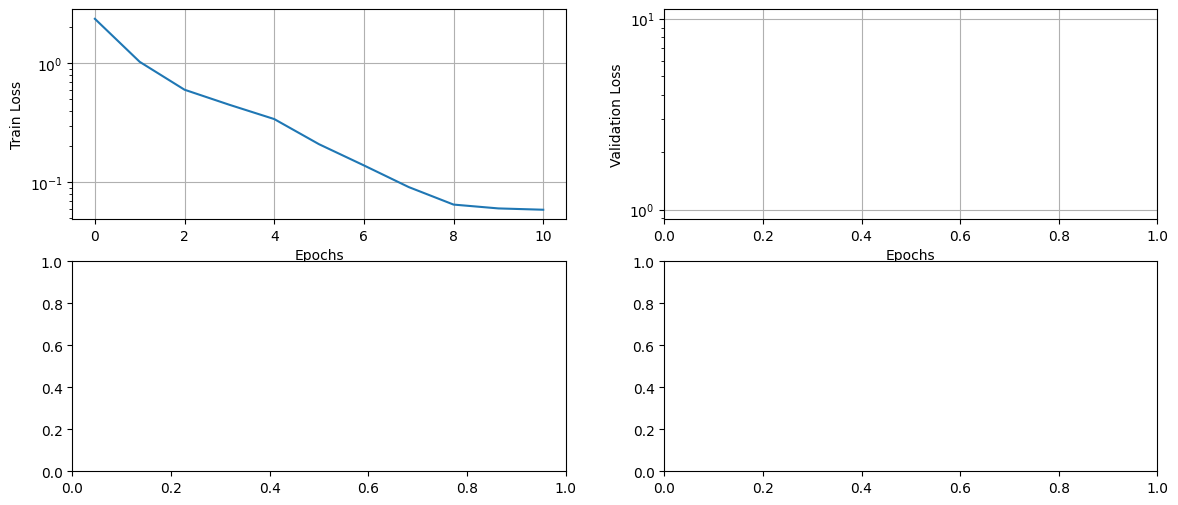

In [3]:
import copy
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
# Define the model
model = nn.Sequential(
    nn.Linear(28 * 28, 256, dtype=torch.float64),
    nn.ReLU(),
    nn.Linear(256, 10, dtype=torch.float64)
).to(dtype=torch.float64)
initial_model_state = copy.deepcopy(model.state_dict())

params = {
    'num_epochs': 10,
    'lr': 0.01,
    'gamma': 0.1,
    'c_init': 1.,
    'batch_size': 64,
    'eps': 1e-3
}
num_epochs = params['num_epochs']
lr = params['lr']
batch_size = params['batch_size']
gamma = params['gamma']
c_init = params['c_init']
eps = params['eps']

criterion = nn.CrossEntropyLoss()
sgd = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
kd_ub = KineticDescentUB(model.parameters(), lr=lr, gamma=gamma, c_init=c_init, eps=eps)
optimizers = {'KD-UB': kd_ub}#, 'SGD-m': sgd}
train_loader, val_loader, test_loader = load_data(batch_size, dataset_name="MNIST")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6))
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss')
ax1.grid()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss')
ax2.grid()

for opt in optimizers.keys():
    model.load_state_dict(copy.deepcopy(initial_model_state))
    optimizer = optimizers[opt]
    model_trained, train_loss_values, val_loss_values, train_acc_values, test_acc_values = train(
        model, optimizer, criterion, train_loader, val_loader, test_loader,
        num_epochs=num_epochs, scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2), flatten=True
    )
    train_accuracy, test_accuracy = evaluate(
        model_trained, test_loader, train_loader, flatten=True
    )
    print(f"{opt}: Final Train Acc: {train_accuracy}, Final Test Acc: {test_accuracy} ")
    ax1.semilogy(np.arange(num_epochs+1), train_loss_values, label=opt)
    if opt in ['KD-RED', 'KD-RK4', 'KD-UB']:
        ke = []
        t = []
        for i in range(num_epochs * int(50000 // batch_size)):
            ke.append(optimizer.momentum_magnitude_history[i])
            t.append(optimizer.t[i])
        ke = np.array(ke)
        t = np.array(t)
        t = np.arange(0, params['lr'] * len(t), params['lr'])  # Time steps
        ax2.semilogy(t, ke / 8, label=opt, linewidth=1.0)
    ax3.plot(np.arange(num_epochs+1), train_acc_values, label=opt)
    ax4.plot(np.arange(num_epochs+1), test_acc_values, label=opt)
    
ax1.legend()
ax2.semilogy(t, params['c_init'] * np.exp(-params['gamma'] * t), label='Desired KE', color='red', linewidth=1.5)
ax2.legend()
ax2.set_ylabel('KE')
ax3.set_xlabel('t')
ax3.set_ylabel('Train Accuracy')
ax3.legend()
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Test Accuracy')
ax4.legend()
plt.grid(True)
plt.show()

# Is setting lr/10 equivalent to gamma/10?

# Hyperparameter Optimization

In [65]:
import os
import json
import torch
import optuna
import matplotlib.pyplot as plt

def objective(trial):
    # Define the search space for hyperparameters
    lr = trial.suggest_categorical('lr', [0.01, 0.1])
    gamma = trial.suggest_categorical('gamma', [0.1, 0.25, 0.5])
    c_init = trial.suggest_categorical('c_init', [1, 2, 4])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    w1 = trial.suggest_categorical('w1', [0.2, 0.5, 0.8])
    w2 = 1 - w1

    # Print the hyperparameter configuration
    print(f"Trial {trial.number} | Hyperparameters: lr={lr}, gamma={gamma}, c_init={c_init}, "
          f"batch_size={batch_size}, w1={w1}, w2={w2}")

    # Fixed parameters
    num_epochs = 10

    # Model and criterion
    model = nn.Sequential(
        nn.Linear(28 * 28, 256, dtype=torch.float64),
        nn.ReLU(),
        nn.Linear(256, 10, dtype=torch.float64)
    ).to(dtype=torch.float64)
    criterion = nn.CrossEntropyLoss()

    # Optimizer with parameter groups
    param_groups = [
        {'params': model[0].parameters(), 'lr': lr, 'gamma': gamma, 'c_init': c_init * w1},
        {'params': model[2].parameters(), 'lr': lr, 'gamma': gamma, 'c_init': c_init * w2}
    ]
    optimizer = KineticDescent(param_groups)

    # Data loaders
    train_loader, val_loader, test_loader = load_data(batch_size, dataset_name="MNIST")

    # Use the original train function
    model_trained, train_loss_values, val_loss_values = train(
        model, optimizer, criterion, train_loader, val_loader,
        num_epochs=num_epochs, scheduler=None, flatten=True
    )

    # Evaluate the model
    train_accuracy, test_accuracy = evaluate(
        model_trained, test_loader, train_loader, flatten=True
    )

    # Print the final metrics
    print(f"Trial {trial.number} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")

    # Create a dedicated folder for this trial
    trial_folder = f"models/trial_{trial.number}"
    os.makedirs(trial_folder, exist_ok=True)

    # Save the model in the trial folder
    model_save_path = os.path.join(trial_folder, "model.pt")
    torch.save(model.state_dict(), model_save_path)

    # Save trial details to a JSON file in the trial folder
    trial_results = {
        'trial': trial.number,
        'hyperparameters': {
            'lr': lr, 'gamma': gamma, 'c_init': c_init, 'batch_size': batch_size, 'w1': w1, 'w2': w2
        },
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss_values': train_loss_values,
        'val_loss_values': val_loss_values
    }
    json_save_path = os.path.join(trial_folder, "results.json")
    with open(json_save_path, 'w') as f:
        json.dump(trial_results, f, indent=4)

    # Plot the loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_loss_values, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Loss Curves for Trial {trial.number}")
    plt.legend()
    plt.grid(True)

    # Save the loss plot in the trial folder
    plot_save_path = os.path.join(trial_folder, "loss_curves.png")
    plt.savefig(plot_save_path)
    plt.close()

    print(f"Model, results, and loss curves saved for Trial {trial.number} in folder: {trial_folder}")

    # Return the test accuracy as the objective value for Optuna to maximize
    return test_accuracy

In [66]:
# Create and run the study
study = optuna.create_study(direction='maximize')  # We want to maximize test accuracy
study.optimize(objective, n_trials=50)

# Display the best trial
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")


[I 2024-12-12 17:45:53,948] A new study created in memory with name: no-name-1abcd7dc-45a6-476e-af3e-91e8799d92b7


Trial 0 | Hyperparameters: lr=0.01, gamma=0.25, c_init=2, batch_size=32, w1=0.2, w2=0.8


/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_40679/1884011138.py:55: RuntimeWarning: overflow encountered in cosh
  A = np.cosh(kappa) / np.cosh(alpha * h + kappa)
/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_40679/1884011138.py:57: RuntimeWarning: overflow encountered in exp
  sech = lambda x: 2/(np.exp(x) + np.exp(-x))
[I 2024-12-12 17:46:56,382] Trial 0 finished with value: 94.69999999999999 and parameters: {'lr': 0.01, 'gamma': 0.25, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 0 with value: 94.69999999999999.


Trial 0 | Train Accuracy: 95.2220 | Test Accuracy: 94.7000
Model, results, and loss curves saved for Trial 0 in folder: models/trial_0
Trial 1 | Hyperparameters: lr=0.1, gamma=0.25, c_init=4, batch_size=128, w1=0.2, w2=0.8


[I 2024-12-12 17:47:36,248] Trial 1 finished with value: 94.8 and parameters: {'lr': 0.1, 'gamma': 0.25, 'c_init': 4, 'batch_size': 128, 'w1': 0.2}. Best is trial 1 with value: 94.8.


Trial 1 | Train Accuracy: 95.2840 | Test Accuracy: 94.8000
Model, results, and loss curves saved for Trial 1 in folder: models/trial_1
Trial 2 | Hyperparameters: lr=0.01, gamma=0.5, c_init=1, batch_size=32, w1=0.5, w2=0.5


[I 2024-12-12 17:48:40,545] Trial 2 finished with value: 91.67999999999999 and parameters: {'lr': 0.01, 'gamma': 0.5, 'c_init': 1, 'batch_size': 32, 'w1': 0.5}. Best is trial 1 with value: 94.8.


Trial 2 | Train Accuracy: 91.3220 | Test Accuracy: 91.6800
Model, results, and loss curves saved for Trial 2 in folder: models/trial_2
Trial 3 | Hyperparameters: lr=0.01, gamma=0.25, c_init=2, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 17:49:20,740] Trial 3 finished with value: 96.1 and parameters: {'lr': 0.01, 'gamma': 0.25, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 3 with value: 96.1.


Trial 3 | Train Accuracy: 97.0560 | Test Accuracy: 96.1000
Model, results, and loss curves saved for Trial 3 in folder: models/trial_3
Trial 4 | Hyperparameters: lr=0.1, gamma=0.1, c_init=2, batch_size=64, w1=0.5, w2=0.5


[I 2024-12-12 17:50:08,434] Trial 4 finished with value: 96.44 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 2, 'batch_size': 64, 'w1': 0.5}. Best is trial 4 with value: 96.44.


Trial 4 | Train Accuracy: 97.1800 | Test Accuracy: 96.4400
Model, results, and loss curves saved for Trial 4 in folder: models/trial_4
Trial 5 | Hyperparameters: lr=0.01, gamma=0.5, c_init=4, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 17:51:10,783] Trial 5 finished with value: 93.43 and parameters: {'lr': 0.01, 'gamma': 0.5, 'c_init': 4, 'batch_size': 32, 'w1': 0.2}. Best is trial 4 with value: 96.44.


Trial 5 | Train Accuracy: 93.3060 | Test Accuracy: 93.4300
Model, results, and loss curves saved for Trial 5 in folder: models/trial_5
Trial 6 | Hyperparameters: lr=0.1, gamma=0.25, c_init=4, batch_size=64, w1=0.8, w2=0.19999999999999996


[I 2024-12-12 17:51:58,796] Trial 6 finished with value: 94.6 and parameters: {'lr': 0.1, 'gamma': 0.25, 'c_init': 4, 'batch_size': 64, 'w1': 0.8}. Best is trial 4 with value: 96.44.


Trial 6 | Train Accuracy: 94.5820 | Test Accuracy: 94.6000
Model, results, and loss curves saved for Trial 6 in folder: models/trial_6
Trial 7 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 17:52:38,194] Trial 7 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.5}. Best is trial 7 with value: 96.66.


Trial 7 | Train Accuracy: 98.1200 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 7 in folder: models/trial_7
Trial 8 | Hyperparameters: lr=0.1, gamma=0.5, c_init=1, batch_size=32, w1=0.5, w2=0.5


/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_40679/1884011138.py:54: RuntimeWarning: invalid value encountered in arctanh
  kappa = np.arctanh(eta)
[I 2024-12-12 17:53:39,405] Trial 8 finished with value: 9.8 and parameters: {'lr': 0.1, 'gamma': 0.5, 'c_init': 1, 'batch_size': 32, 'w1': 0.5}. Best is trial 7 with value: 96.66.


Trial 8 | Train Accuracy: 9.9460 | Test Accuracy: 9.8000
Model, results, and loss curves saved for Trial 8 in folder: models/trial_8
Trial 9 | Hyperparameters: lr=0.01, gamma=0.25, c_init=1, batch_size=64, w1=0.5, w2=0.5


[I 2024-12-12 17:54:27,582] Trial 9 finished with value: 95.25 and parameters: {'lr': 0.01, 'gamma': 0.25, 'c_init': 1, 'batch_size': 64, 'w1': 0.5}. Best is trial 7 with value: 96.66.


Trial 9 | Train Accuracy: 95.5580 | Test Accuracy: 95.2500
Model, results, and loss curves saved for Trial 9 in folder: models/trial_9
Trial 10 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.8, w2=0.19999999999999996


[I 2024-12-12 17:55:09,095] Trial 10 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.8}. Best is trial 7 with value: 96.66.


Trial 10 | Train Accuracy: 97.7940 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 10 in folder: models/trial_10
Trial 11 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.8, w2=0.19999999999999996


[I 2024-12-12 17:55:48,627] Trial 11 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.8}. Best is trial 7 with value: 96.66.


Trial 11 | Train Accuracy: 97.7940 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 11 in folder: models/trial_11
Trial 12 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.8, w2=0.19999999999999996


[I 2024-12-12 17:56:28,372] Trial 12 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.8}. Best is trial 7 with value: 96.66.


Trial 12 | Train Accuracy: 97.7940 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 12 in folder: models/trial_12
Trial 13 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.8, w2=0.19999999999999996


[I 2024-12-12 17:57:07,551] Trial 13 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.8}. Best is trial 7 with value: 96.66.


Trial 13 | Train Accuracy: 97.7940 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 13 in folder: models/trial_13
Trial 14 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.8, w2=0.19999999999999996


[I 2024-12-12 17:57:47,570] Trial 14 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.8}. Best is trial 7 with value: 96.66.


Trial 14 | Train Accuracy: 97.7940 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 14 in folder: models/trial_14
Trial 15 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 17:58:26,976] Trial 15 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.5}. Best is trial 7 with value: 96.66.


Trial 15 | Train Accuracy: 98.1200 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 15 in folder: models/trial_15
Trial 16 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.8, w2=0.19999999999999996


[I 2024-12-12 17:59:06,361] Trial 16 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.8}. Best is trial 7 with value: 96.66.


Trial 16 | Train Accuracy: 97.7940 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 16 in folder: models/trial_16
Trial 17 | Hyperparameters: lr=0.1, gamma=0.1, c_init=4, batch_size=128, w1=0.8, w2=0.19999999999999996


[I 2024-12-12 17:59:45,672] Trial 17 finished with value: 96.66 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 4, 'batch_size': 128, 'w1': 0.8}. Best is trial 7 with value: 96.66.


Trial 17 | Train Accuracy: 97.7940 | Test Accuracy: 96.6600
Model, results, and loss curves saved for Trial 17 in folder: models/trial_17
Trial 18 | Hyperparameters: lr=0.1, gamma=0.1, c_init=2, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 18:00:24,895] Trial 18 finished with value: 97.08 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 18 with value: 97.08.


Trial 18 | Train Accuracy: 98.1560 | Test Accuracy: 97.0800
Model, results, and loss curves saved for Trial 18 in folder: models/trial_18
Trial 19 | Hyperparameters: lr=0.1, gamma=0.1, c_init=2, batch_size=64, w1=0.5, w2=0.5


[I 2024-12-12 18:01:10,838] Trial 19 finished with value: 96.44 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 2, 'batch_size': 64, 'w1': 0.5}. Best is trial 18 with value: 97.08.


Trial 19 | Train Accuracy: 97.1800 | Test Accuracy: 96.4400
Model, results, and loss curves saved for Trial 19 in folder: models/trial_19
Trial 20 | Hyperparameters: lr=0.1, gamma=0.5, c_init=2, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 18:01:49,580] Trial 20 finished with value: 91.41 and parameters: {'lr': 0.1, 'gamma': 0.5, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 18 with value: 97.08.


Trial 20 | Train Accuracy: 90.8380 | Test Accuracy: 91.4100
Model, results, and loss curves saved for Trial 20 in folder: models/trial_20
Trial 21 | Hyperparameters: lr=0.1, gamma=0.1, c_init=2, batch_size=128, w1=0.5, w2=0.5
Trial 21 | Train Accuracy: 98.1560 | Test Accuracy: 97.0800


[I 2024-12-12 18:02:28,578] Trial 21 finished with value: 97.08 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 18 with value: 97.08.


Model, results, and loss curves saved for Trial 21 in folder: models/trial_21
Trial 22 | Hyperparameters: lr=0.1, gamma=0.1, c_init=2, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 18:03:07,563] Trial 22 finished with value: 97.08 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 18 with value: 97.08.


Trial 22 | Train Accuracy: 98.1560 | Test Accuracy: 97.0800
Model, results, and loss curves saved for Trial 22 in folder: models/trial_22
Trial 23 | Hyperparameters: lr=0.1, gamma=0.1, c_init=2, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 18:03:46,363] Trial 23 finished with value: 97.08 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 18 with value: 97.08.


Trial 23 | Train Accuracy: 98.1560 | Test Accuracy: 97.0800
Model, results, and loss curves saved for Trial 23 in folder: models/trial_23
Trial 24 | Hyperparameters: lr=0.1, gamma=0.1, c_init=2, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 18:04:24,475] Trial 24 finished with value: 97.08 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 18 with value: 97.08.


Trial 24 | Train Accuracy: 98.1560 | Test Accuracy: 97.0800
Model, results, and loss curves saved for Trial 24 in folder: models/trial_24
Trial 25 | Hyperparameters: lr=0.1, gamma=0.1, c_init=2, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 18:05:03,008] Trial 25 finished with value: 97.08 and parameters: {'lr': 0.1, 'gamma': 0.1, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 18 with value: 97.08.


Trial 25 | Train Accuracy: 98.1560 | Test Accuracy: 97.0800
Model, results, and loss curves saved for Trial 25 in folder: models/trial_25
Trial 26 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=128, w1=0.5, w2=0.5


[I 2024-12-12 18:05:41,650] Trial 26 finished with value: 97.11 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 128, 'w1': 0.5}. Best is trial 26 with value: 97.11.


Trial 26 | Train Accuracy: 98.9500 | Test Accuracy: 97.1100
Model, results, and loss curves saved for Trial 26 in folder: models/trial_26
Trial 27 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=128, w1=0.2, w2=0.8


[I 2024-12-12 18:06:19,979] Trial 27 finished with value: 97.28 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 128, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 27 | Train Accuracy: 99.6580 | Test Accuracy: 97.2800
Model, results, and loss curves saved for Trial 27 in folder: models/trial_27
Trial 28 | Hyperparameters: lr=0.01, gamma=0.5, c_init=2, batch_size=64, w1=0.2, w2=0.8


[I 2024-12-12 18:07:05,344] Trial 28 finished with value: 92.69 and parameters: {'lr': 0.01, 'gamma': 0.5, 'c_init': 2, 'batch_size': 64, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 28 | Train Accuracy: 92.5760 | Test Accuracy: 92.6900
Model, results, and loss curves saved for Trial 28 in folder: models/trial_28
Trial 29 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:08:06,306] Trial 29 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 29 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 29 in folder: models/trial_29
Trial 30 | Hyperparameters: lr=0.01, gamma=0.25, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:09:06,411] Trial 30 finished with value: 94.91000000000001 and parameters: {'lr': 0.01, 'gamma': 0.25, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 30 | Train Accuracy: 95.3940 | Test Accuracy: 94.9100
Model, results, and loss curves saved for Trial 30 in folder: models/trial_30
Trial 31 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:10:06,072] Trial 31 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 31 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 31 in folder: models/trial_31
Trial 32 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:11:05,319] Trial 32 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 32 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 32 in folder: models/trial_32
Trial 33 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:12:00,885] Trial 33 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 33 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 33 in folder: models/trial_33
Trial 34 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:12:56,978] Trial 34 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 34 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 34 in folder: models/trial_34
Trial 35 | Hyperparameters: lr=0.01, gamma=0.25, c_init=1, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:13:52,758] Trial 35 finished with value: 93.97999999999999 and parameters: {'lr': 0.01, 'gamma': 0.25, 'c_init': 1, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 35 | Train Accuracy: 94.1860 | Test Accuracy: 93.9800
Model, results, and loss curves saved for Trial 35 in folder: models/trial_35
Trial 36 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:14:47,846] Trial 36 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 36 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 36 in folder: models/trial_36
Trial 37 | Hyperparameters: lr=0.01, gamma=0.5, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:15:43,391] Trial 37 finished with value: 92.27 and parameters: {'lr': 0.01, 'gamma': 0.5, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 37 | Train Accuracy: 92.1160 | Test Accuracy: 92.2700
Model, results, and loss curves saved for Trial 37 in folder: models/trial_37
Trial 38 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:16:38,983] Trial 38 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 38 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 38 in folder: models/trial_38
Trial 39 | Hyperparameters: lr=0.01, gamma=0.25, c_init=1, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:17:33,638] Trial 39 finished with value: 93.97999999999999 and parameters: {'lr': 0.01, 'gamma': 0.25, 'c_init': 1, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 39 | Train Accuracy: 94.1860 | Test Accuracy: 93.9800
Model, results, and loss curves saved for Trial 39 in folder: models/trial_39
Trial 40 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:18:28,972] Trial 40 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 40 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 40 in folder: models/trial_40
Trial 41 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:19:23,267] Trial 41 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 41 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 41 in folder: models/trial_41
Trial 42 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:20:18,995] Trial 42 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 42 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 42 in folder: models/trial_42
Trial 43 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:21:14,373] Trial 43 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 43 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 43 in folder: models/trial_43
Trial 44 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:22:09,221] Trial 44 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 44 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 44 in folder: models/trial_44
Trial 45 | Hyperparameters: lr=0.01, gamma=0.5, c_init=1, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:23:03,066] Trial 45 finished with value: 90.94 and parameters: {'lr': 0.01, 'gamma': 0.5, 'c_init': 1, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 45 | Train Accuracy: 90.4840 | Test Accuracy: 90.9400
Model, results, and loss curves saved for Trial 45 in folder: models/trial_45
Trial 46 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:23:57,616] Trial 46 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 46 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 46 in folder: models/trial_46
Trial 47 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:24:52,453] Trial 47 finished with value: 97.2 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 47 | Train Accuracy: 98.9700 | Test Accuracy: 97.2000
Model, results, and loss curves saved for Trial 47 in folder: models/trial_47
Trial 48 | Hyperparameters: lr=0.01, gamma=0.25, c_init=2, batch_size=32, w1=0.2, w2=0.8


[I 2024-12-12 18:25:47,460] Trial 48 finished with value: 94.91000000000001 and parameters: {'lr': 0.01, 'gamma': 0.25, 'c_init': 2, 'batch_size': 32, 'w1': 0.2}. Best is trial 27 with value: 97.28.


Trial 48 | Train Accuracy: 95.3940 | Test Accuracy: 94.9100
Model, results, and loss curves saved for Trial 48 in folder: models/trial_48
Trial 49 | Hyperparameters: lr=0.01, gamma=0.1, c_init=2, batch_size=64, w1=0.2, w2=0.8


[I 2024-12-12 18:26:30,459] Trial 49 finished with value: 97.34 and parameters: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 64, 'w1': 0.2}. Best is trial 49 with value: 97.34.


Trial 49 | Train Accuracy: 99.7720 | Test Accuracy: 97.3400
Model, results, and loss curves saved for Trial 49 in folder: models/trial_49
Best trial:
  Value: 97.34
  Params: {'lr': 0.01, 'gamma': 0.1, 'c_init': 2, 'batch_size': 64, 'w1': 0.2}


In [ ]:
# Robbins Monro
# Rescaling force